## C. difficile Microbiome Analysis Pipeline
***16S Amplicon Sequencing Analysis***  

___William Sano___
___FISH546 - Dr. Stephen Roberts F18___  
___November 16, 2018___

## 1) Data Importing
### Make sure that you have initialized a Qiime2 (ver. 2018.8) environment in conda. Instructions [here](https://docs.qiime2.org/2018.8/tutorials/filtering/)

16s data from Clostridium difficile positive (CDI+) and negative control (CDI-) patients downloaded from published study, BioProject:PRJNA353065, downloaded with the ENA downloader software v1.2.2 to `data/C_diff/raw`

Excluded patient_73 (SAMN06011323, SRR5040671) and patient_11 (SAMN06011261, SRR5040732) samples due to an order of magnitude difference in read count, suggesting poor demultiplexing.

**Sequence data downloaded from the ENA 11.27.18, 2:22pm**  



In [3]:
%%bash
java -jar /*path_to_ena_downloader*/ena-file-downloader-v1.2.2.jar

Error: Could not find or load main class uk.ac.ebi.ena.downloader.gui.Main


In [8]:
%%bash
SRRlist=$(find data/raw -name "*.fastq.gz" | xargs -n 1 basename | cut -d '_' -f 1 | sort | uniq)
echo $SRRlist

gunzip data/raw/*

echo -e "sample-id,absolute-filepath,direction" > scripts/C_diff_manifest.csv

for file in ${SRRlist[@]}
do

for_link=$(greadlink -f "data/raw/"$file"_1.fastq")
rev_link=$(greadlink -f "data/raw/"$file"_2.fastq")


echo -e "$file,$for_link,forward" >> scripts/C_diff_manifest.csv
echo -e "$file,$rev_link,reverse" >> scripts/C_diff_manifest.csv


done
head -n 10 scripts/C_diff_manifest.csv

SRR5040666 SRR5040667 SRR5040668 SRR5040669 SRR5040670 SRR5040672 SRR5040673 SRR5040674 SRR5040675 SRR5040676 SRR5040677 SRR5040678 SRR5040679 SRR5040680 SRR5040681 SRR5040682 SRR5040683 SRR5040684 SRR5040685 SRR5040686 SRR5040687 SRR5040688 SRR5040689 SRR5040690 SRR5040691 SRR5040692 SRR5040693 SRR5040694 SRR5040695 SRR5040696 SRR5040697 SRR5040698 SRR5040699 SRR5040700 SRR5040701 SRR5040702 SRR5040703 SRR5040704 SRR5040705 SRR5040706 SRR5040707 SRR5040708 SRR5040709 SRR5040710 SRR5040711 SRR5040712 SRR5040713 SRR5040714 SRR5040715 SRR5040716 SRR5040717 SRR5040718 SRR5040719 SRR5040720 SRR5040721 SRR5040722 SRR5040723 SRR5040724 SRR5040725 SRR5040726 SRR5040727 SRR5040728 SRR5040729 SRR5040730 SRR5040731 SRR5040733 SRR5040734 SRR5040735 SRR5040736 SRR5040737 SRR5040738 SRR5040739 SRR5040740 SRR5040741 SRR5040742 SRR5040743 SRR5040744
sample-id,absolute-filepath,direction
SRR5040666,/Users/williamsano/Documents/GitHub/will-Chiru16S/C_diff/data/raw/SRR5040666_1.fastq,forward
SRR5040666,

#### Importing `.fastq` files into Qiime2 environment via fastq manifest format
Phred score is 33  

In [12]:
!qiime tools import --type 'SampleData[PairedEndSequencesWithQuality]' --input-path scripts/C_diff_manifest.csv --output-path data/demux.qza --input-format PairedEndFastqManifestPhred33

Imported scripts/C_diff_manifest.csv as PairedEndFastqManifestPhred33 to data/demux.qza


### 2) Sequence Pre-processing
#### Running fastqc FastQC v0.11.8 on all fastq files

In [10]:
!mkdir analyses/fastqc
!/Applications/bioinformatics/FastQC/fastqc data/raw/*.fastq -o analyses/fastqc
!rm analyses/fastqc/*.zip

mkdir: analyses/fastqc: File exists
Started analysis of SRR5040666_1.fastq
Approx 5% complete for SRR5040666_1.fastq
Approx 10% complete for SRR5040666_1.fastq
Approx 15% complete for SRR5040666_1.fastq
Approx 20% complete for SRR5040666_1.fastq
Approx 25% complete for SRR5040666_1.fastq
Approx 30% complete for SRR5040666_1.fastq
Approx 35% complete for SRR5040666_1.fastq
Approx 40% complete for SRR5040666_1.fastq
Approx 45% complete for SRR5040666_1.fastq
Approx 50% complete for SRR5040666_1.fastq
Approx 55% complete for SRR5040666_1.fastq
Approx 60% complete for SRR5040666_1.fastq
Approx 65% complete for SRR5040666_1.fastq
Approx 70% complete for SRR5040666_1.fastq
Approx 75% complete for SRR5040666_1.fastq
Approx 80% complete for SRR5040666_1.fastq
Approx 85% complete for SRR5040666_1.fastq
Approx 90% complete for SRR5040666_1.fastq
Approx 95% complete for SRR5040666_1.fastq
Analysis complete for SRR5040666_1.fastq
^C


In [13]:
!qiime demux summarize --i-data data/demux.qza --o-visualization data/demux.qzv

Saved Visualization to: data/demux.qzv


 Based on readout from `demux.qzv` file and fastqc, trimming forward and reverse reads at pos 20 (from left) and 600 (from right) with DADA2. This step also completes denoising and chimera checking by consensus method.
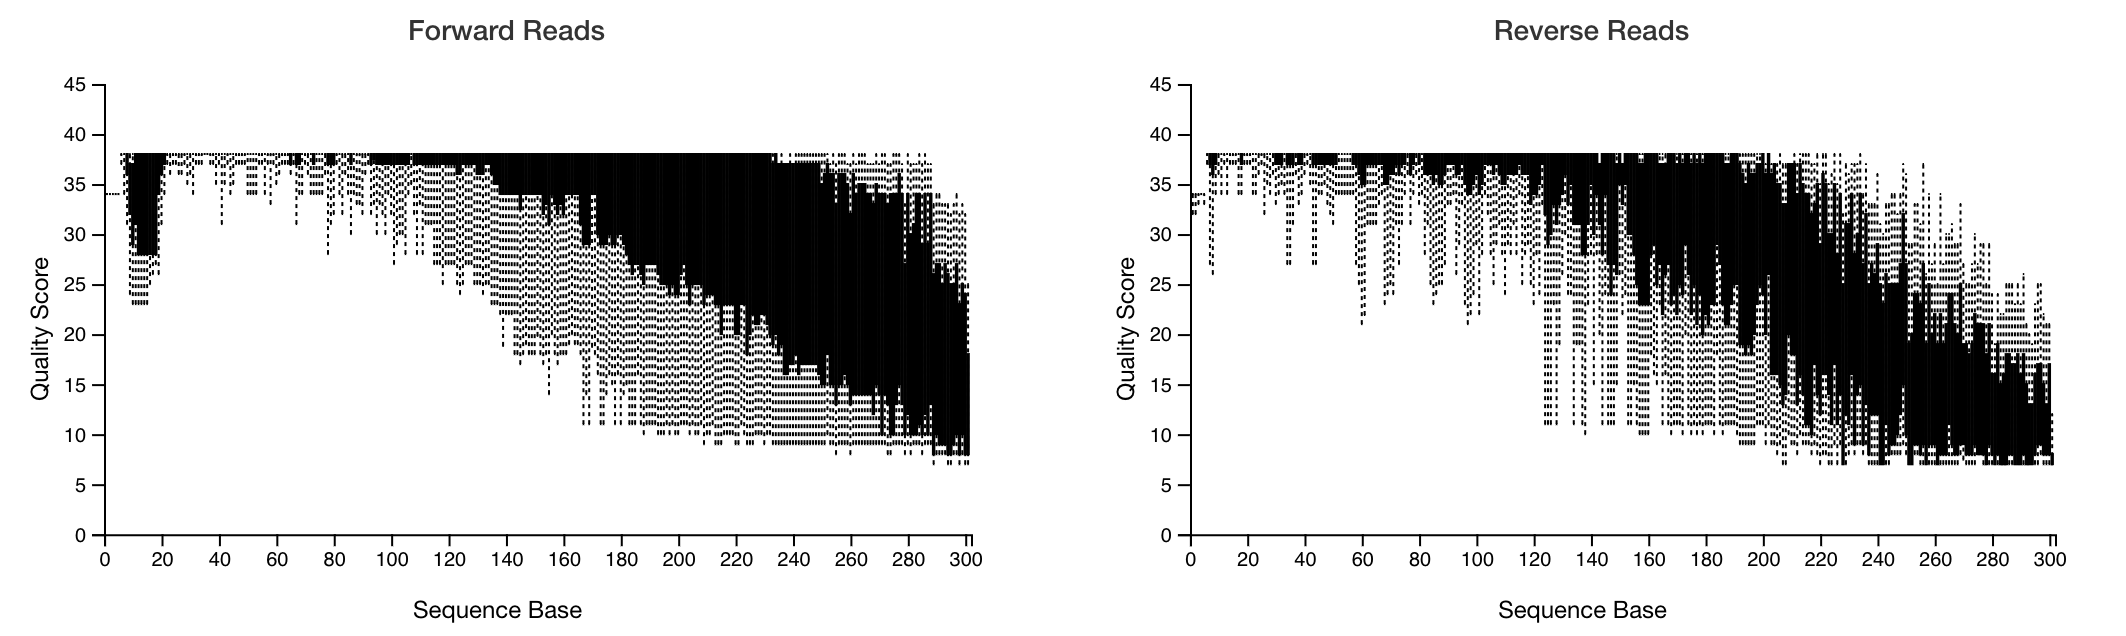

In [ ]:
#denoising in DADA2
!qiime dada2 denoise-paired \
  --i-demultiplexed-seqs data/demux.qza \
  --o-table data/table.qza \
  --o-representative-sequences data/rep-seqs.qza \
  --o-denoising-stats data/denoising-stats.qza \
  --p-trim-left-f 20 \
  --p-trim-left-r 20 \
  --p-n-threads 0 \
  --p-trunc-q 25

In [4]:
!qiime dada2 denoise-single --help

Usage: qiime dada2 denoise-single [OPTIONS]

  This method denoises single-end sequences, dereplicates them, and filters
  chimeras.

Options:
  --i-demultiplexed-seqs ARTIFACT PATH SampleData[PairedEndSequencesWithQuality | SequencesWithQuality]
                                  The single-end demultiplexed sequences to be
                                  denoised.  [required]
  --p-trunc-len INTEGER           Position at which sequences should be
                                  truncated due to decrease in quality. This
                                  truncates the 3' end of the of the input
                                  sequences, which will be the bases that were
                                  sequenced in the last cycles. Reads that are
                                  shorter than this value will be discarded.
                                  If 0 is provided, no truncation or length
                                  filtering will be performed  [required]
  --p-tri

### 3) Make summary outputs  
*Highly* permissive trimming in DADA2 required to achieve 20bp overlap necessary for paired-end denoising. Therefore, created summary outputs from single-end (R1 only) and paired-end amplicon sequence variant (ASV) tables and denoising stats.  


### __single end__ - ASV table summary, representative sequences, and denoising stats

In [4]:
!qiime feature-table summarize \
  --i-table data/Yue/se-table.qza \
  --o-visualization data/Yue/se-table.qzv \
  --m-sample-metadata-file scripts/mapping.txt

!qiime feature-table tabulate-seqs \
  --i-data data/Yue/se-rep-seqs.qza \
  --o-visualization data/Yue/se-rep-seqs.qzv

!qiime metadata tabulate \
  --m-input-file data/Yue/se-denoising-stats.qza
  --o-visualization data/Yue/se-denoising-stats.qzv

Saved Visualization to: data/Yue/se-table.qzv
Saved Visualization to: data/Yue/se-rep-seqs.qzv


> ### output: `se-table.qzv`
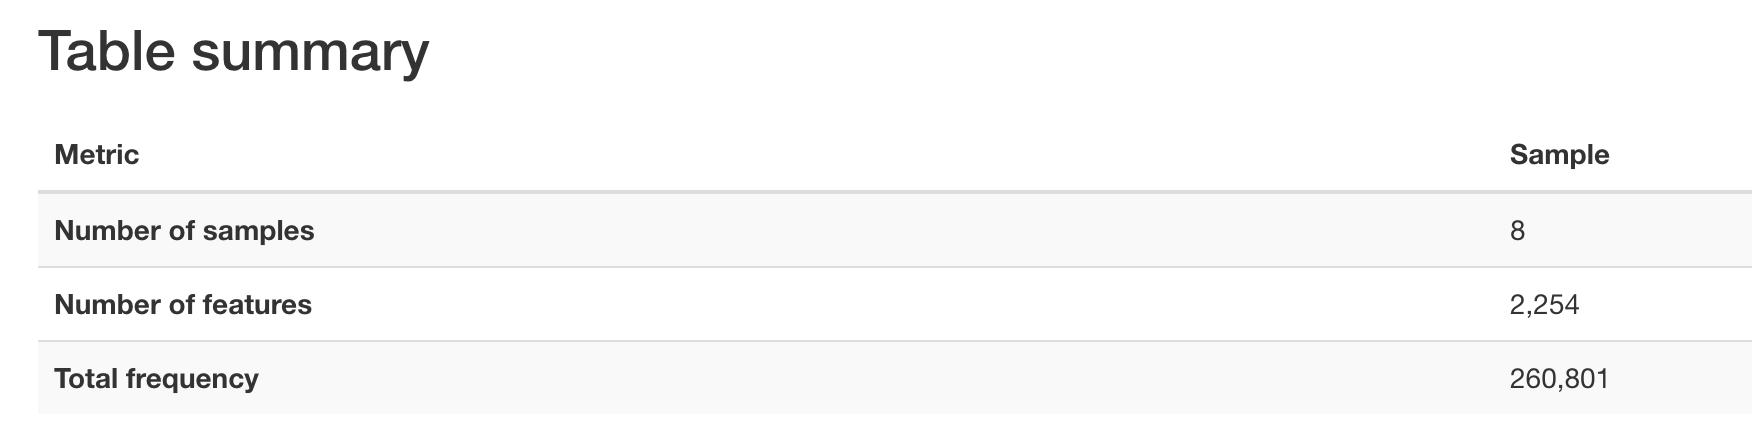

> ### output: `se-denoising-stats.qzv`
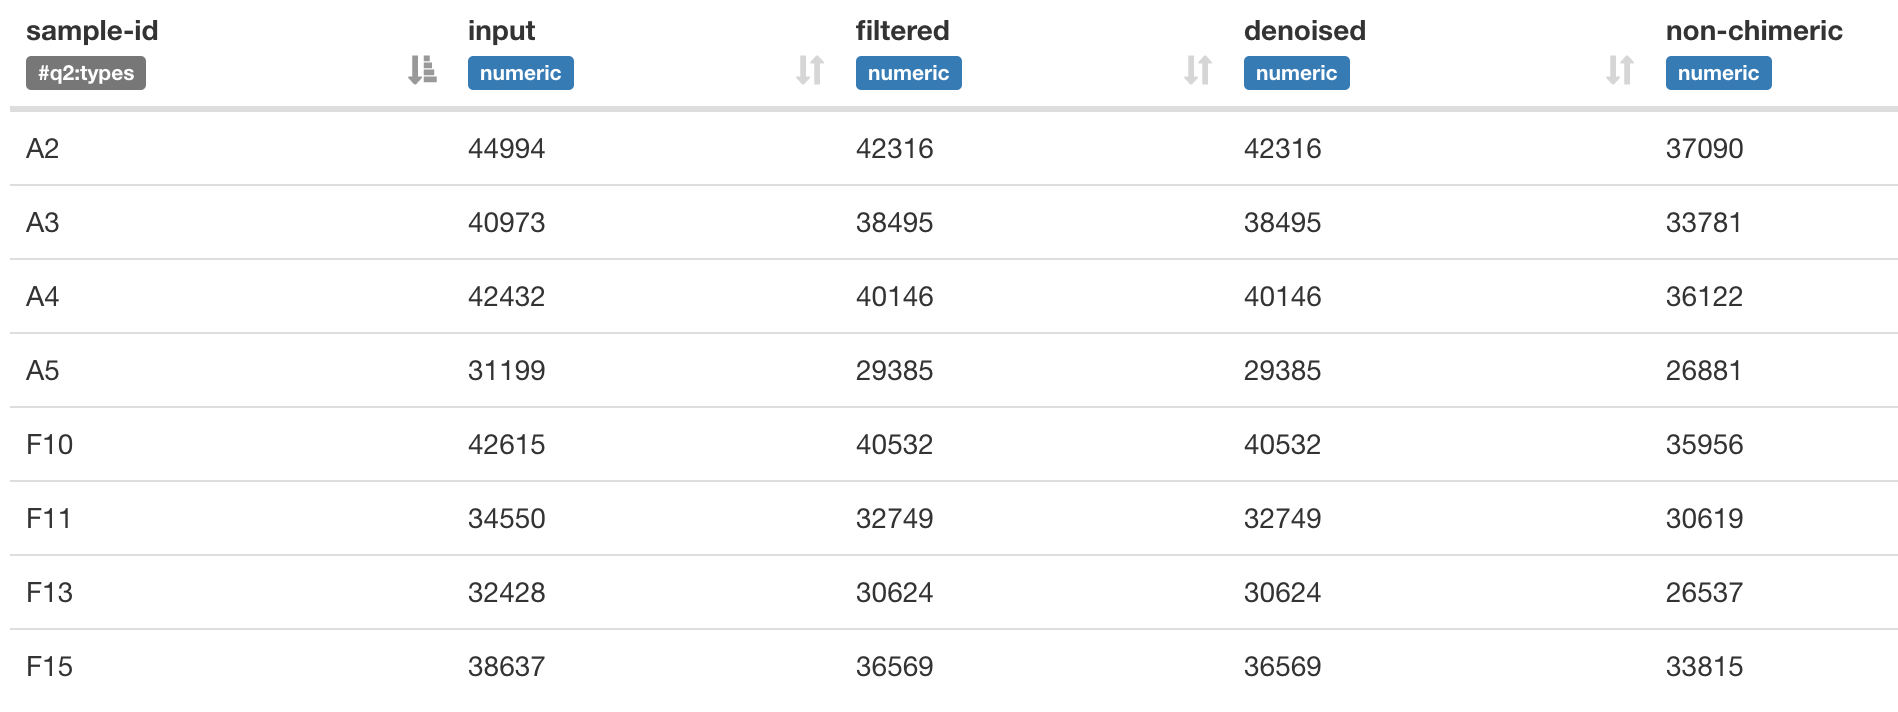

###  __paired end__ - ASV table summary, representative sequences, and denoising stats

In [19]:
!qiime feature-table summarize \
  --i-table data/Yue/pe-table.qza \
  --o-visualization data/Yue/pe-table.qzv \
  --m-sample-metadata-file scripts/mapping.txt

!qiime feature-table tabulate-seqs \
  --i-data data/Yue/pe-rep-seqs.qza \
  --o-visualization data/Yue/pe-rep-seqs.qzv

!qiime metadata tabulate \
  --m-input-file data/Yue/pe-denoising-stats.qza \
  --o-visualization data/Yue/pe-denoising-stats.qzv

Saved Visualization to: data/Yue/pe-table.qzv
Saved Visualization to: data/Yue/pe-rep-seqs.qzv
Saved Visualization to: data/Yue/pe-denoising-stats.qzv


> ### output: `pe-table.qzv`
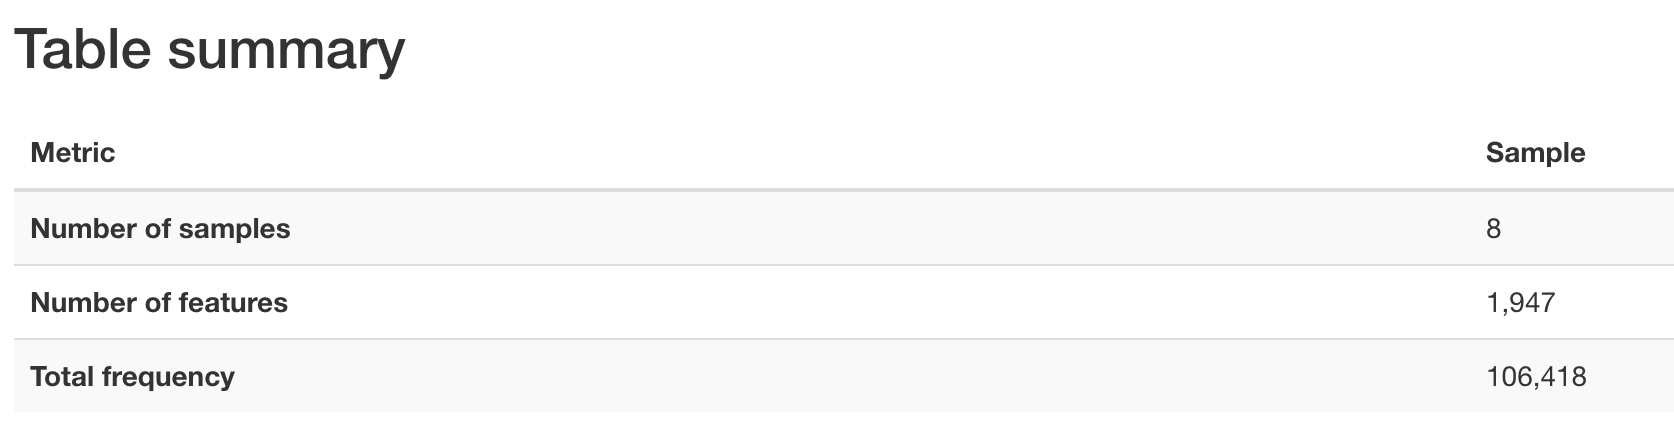

> ### output: `pe-denoising-stats.qzv`
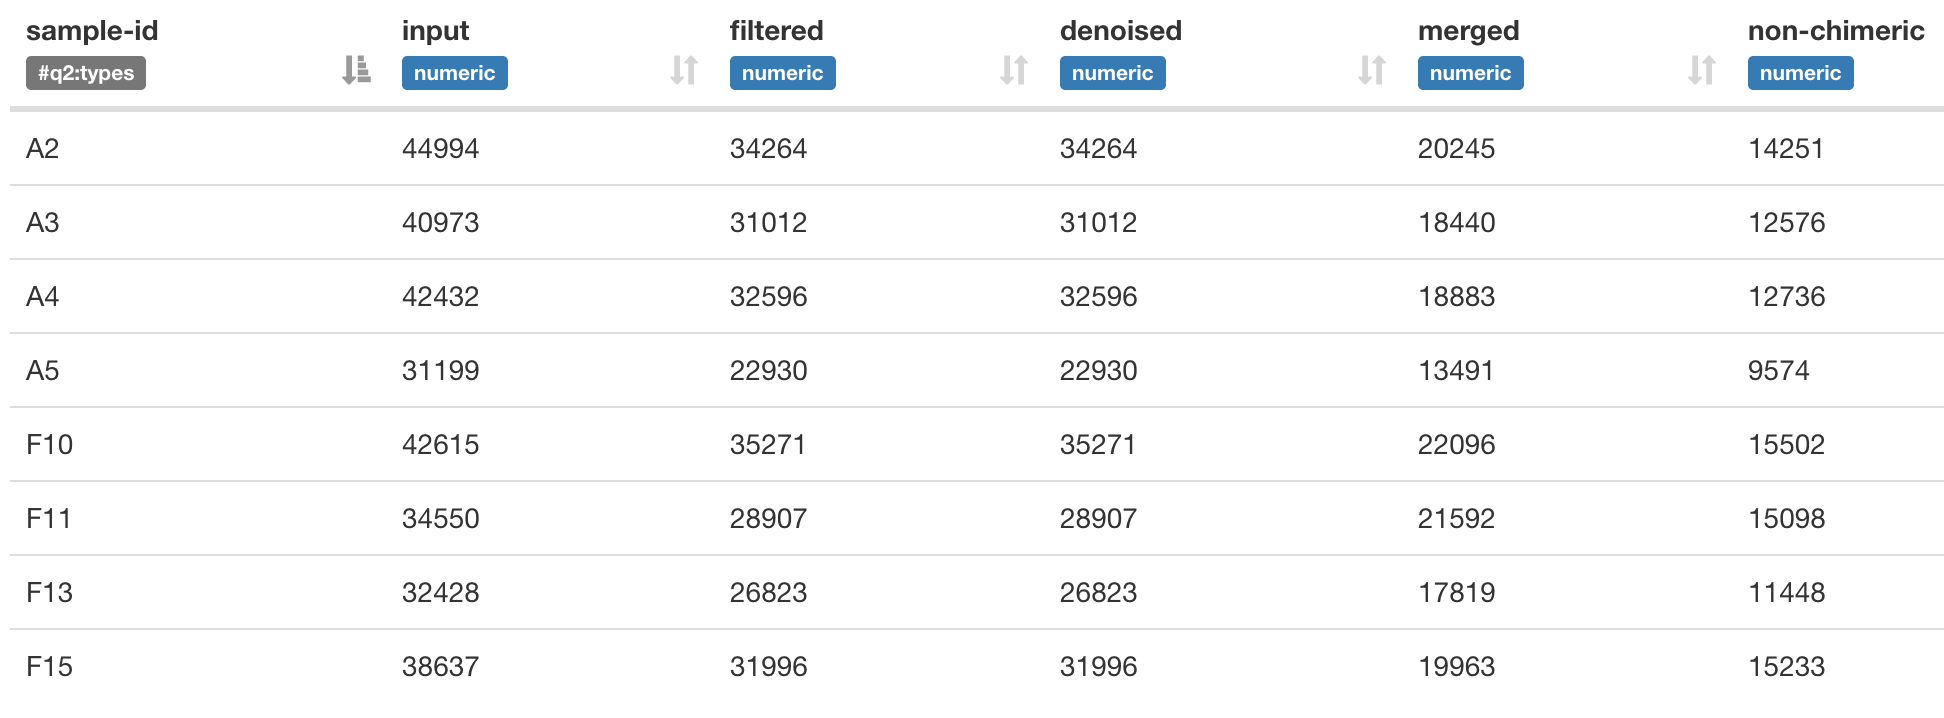

The `pe-denoising-stats.qzv` visualization shows greater chimera reduction between merged and non-chimeric columns. Ideally I would move forward with paired-end data, but see error below.

### 4) Retrieving SILVA 99% identity OTU naive Bayes classifier for the bacterial 16S gene

In [1]:
!wget -O "silva-132-99-nb-classifier.qza" "https://data.qiime2.org/2018.8/common/silva-132-99-nb-classifier.qza" > data/silva-132-99-nb-classifier.qza

--2018-11-01 10:17:52--  https://data.qiime2.org/2018.8/common/silva-132-99-nb-classifier.qza
Resolving data.qiime2.org (data.qiime2.org)... 104.27.171.158, 104.27.170.158
Connecting to data.qiime2.org (data.qiime2.org)|104.27.171.158|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2018.8/common/silva-132-99-nb-classifier.qza [following]
--2018-11-01 10:17:53--  https://s3-us-west-2.amazonaws.com/qiime2-data/2018.8/common/silva-132-99-nb-classifier.qza
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.209.200
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.209.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643767866 (614M) [binary/octet-stream]
Saving to: ‘silva-132-99-nb-classifier.qza’

silva-132-99-nb-cla 100%[===================>] 613.94M  9.14MB/s    in 55s     

2018-11-01 10:18:48 (11.1 MB/s) - ‘silva-132-99-nb-classi

### 5) Creating feature classifier to assign each of the ASVs in `[se/pe]-rep-seqs.qza` to an OTU in SILVA database.

In [2]:
!qiime feature-classifier classify-sklearn \
  --i-classifier data/silva-132-99-nb-classifier.qza \
  --i-reads data/Yue/se-rep-seqs.qza \
  --o-classification analyses/Yue/se-silva-taxonomy.qza

!qiime metadata tabulate \
  --m-input-file analyses/Yue/se-silva-taxonomy.qza \
  --o-visualization analyses/Yue/se-silva-taxonomy.qzv

Saved FeatureData[Taxonomy] to: analyses/Yue/se-silva-taxonomy.qza
Saved Visualization to: analyses/Yue/se-silva-taxonomy.qzv


In [22]:
!qiime feature-classifier classify-sklearn \
  --i-classifier data/silva-132-99-nb-classifier.qza \
  --i-reads data/Yue/pe-rep-seqs.qza \
  --o-classification analyses/Yue/pe-silva-taxonomy.qza

!qiime metadata tabulate \
  --m-input-file analyses/Yue/pe-silva-taxonomy.qza \
  --o-visualization analyses/Yue/pe-silva-taxonomy.qzv

Plugin error from feature-classifier:

  [Errno 28] No space left on device

Debug info has been saved to /var/folders/fj/lrbc9zxd0pn3ck7w0w70k6ph0000gn/T/qiime2-q2cli-err-i8s4dslv.log
There was an issue with loading the file analyses/Yue/pe-silva-taxonomy.qza as metadata:

  Metadata file path doesn't exist, or the path points to something other than a file. Please check that the path exists, has read permissions, and points to a regular file (not a directory): analyses/Yue/pe-silva-taxonomy.qza

  There may be more errors present in the metadata file. To get a full report, sample/feature metadata files can be validated with Keemei: https://keemei.qiime2.org

  Find details on QIIME 2 metadata requirements here: https://docs.qiime2.org/2018.8/tutorials/metadata/



> ### <span style="color:red"> **ERROR: running out of space on device when I try to run the feature-classifier on my paired-end rep seq file.** text</span>  
*Moving ahead with single-end analysis, but will hopefully be able to get the paired-end taxonomy for my real data when it comes through*


### 6) Filter out chloroplast, mitochondrial contamination

In [6]:
!qiime taxa filter-table \
  --i-table data/Yue/se-table.qza \
  --i-taxonomy analyses/Yue/se-silva-taxonomy.qza \
  --p-exclude mitochondria,chloroplast \
  --o-filtered-table data/Yue/se-table-excl-mitochloro.qza

!qiime feature-table summarize \
  --i-table data/Yue/se-table-excl-mitochloro.qza \
  --o-visualization data/Yue/se-table-excl-mitochloro.qzv \
  --m-sample-metadata-file scripts/mapping.txt

Saved FeatureTable[Frequency] to: data/Yue/se-table-excl-mitochloro.qza
Saved Visualization to: data/Yue/se-table-excl-mitochloro.qzv


### 7) Making tree for phylogenetic analysis

In [7]:
!qiime alignment mafft \
  --i-sequences data/Yue/se-rep-seqs.qza \
  --o-alignment data/Yue/se-aligned-rep-seqs.qza

!qiime alignment mask \
  --i-alignment data/Yue/se-aligned-rep-seqs.qza \
  --o-masked-alignment data/Yue/se-masked-aligned-rep-seqs.qza

!qiime phylogeny fasttree \
  --i-alignment data/Yue/se-masked-aligned-rep-seqs.qza \
  --o-tree data/Yue/se-unrooted-tree.qza

!qiime phylogeny midpoint-root \
  --i-tree data/Yue/se-unrooted-tree.qza \
  --o-rooted-tree data/Yue/se-rooted-tree.qza

Saved FeatureData[AlignedSequence] to: data/Yue/se-aligned-rep-seqs.qza
Saved FeatureData[AlignedSequence] to: data/Yue/se-masked-aligned-rep-seqs.qza
Saved Phylogeny[Unrooted] to: data/Yue/se-unrooted-tree.qza
Saved Phylogeny[Rooted] to: data/Yue/se-rooted-tree.qza


### 8) Phylogenetic Analyses

Sampling depth of 26537 for `core-metrics-phylogenetic` sequence rarefaction set by picking lowest sequence number per sample as shown in `se-table-excl-mitochloro.qzv`. 

In [11]:
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny data/Yue/se-rooted-tree.qza \
  --i-table data/Yue/se-table-excl-mitochloro.qza \
  --p-sampling-depth 26537 \
  --output-dir analyses/Yue/se-excl-mitochloro-corediv-26537 \
  --m-metadata-file scripts/mapping.txt

!qiime diversity alpha-rarefaction \
  --i-table data/Yue/se-table-excl-mitochloro.qza \
  --i-phylogeny data/Yue/se-rooted-tree.qza \
  --p-max-depth 26537 \
  --m-metadata-file scripts/mapping.txt \
  --o-visualization analyses/Yue/se-alpha-rarefaction.qzv

!mkdir -p analyses/Yue/se-excl-mitochloro-corediv-26537/export/PCoA-coordinates

!qiime tools export analyses/Yue/se-excl-mitochloro-corediv-26537/bray_curtis_pcoa_results.qza \
        --output-path analyses/Yue/se-excl-mitochloro-corediv-26537/export/bray_curtis_pcoa_results

Saved FeatureTable[Frequency] to: analyses/Yue/se-excl-mitochloro-corediv-26537/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties(['phylogenetic']) to: analyses/Yue/se-excl-mitochloro-corediv-26537/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: analyses/Yue/se-excl-mitochloro-corediv-26537/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: analyses/Yue/se-excl-mitochloro-corediv-26537/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: analyses/Yue/se-excl-mitochloro-corediv-26537/evenness_vector.qza
Saved DistanceMatrix % Properties(['phylogenetic']) to: analyses/Yue/se-excl-mitochloro-corediv-26537/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties(['phylogenetic']) to: analyses/Yue/se-excl-mitochloro-corediv-26537/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: analyses/Yue/se-excl-mitochloro-corediv-26537/jaccard_distance_matrix.qza
Saved DistanceMatrix to: analyses/Yue/se-excl-mitochloro-corediv-26537/bray

In [18]:
!qiime tools export --input-path analyses/Yue/se-excl-mitochloro-corediv-26537/bray_curtis_pcoa_results.qza \
        --output-path analyses/Yue/se-excl-mitochloro-corediv-26537/export/bray_curtis_pcoa_results
!sed '1,9d' analyses/Yue/se-excl-mitochloro-corediv-26537/export/bray_curtis_pcoa_results/ordination.txt | head -n 8 \
    > analyses/Yue/se-excl-mitochloro-corediv-26537/export/bray_curtis_pcoa_results/coordinates.txt
!head -n 5 analyses/Yue/se-excl-mitochloro-corediv-26537/export/bray_curtis_pcoa_results/ordination.txt | tail -n 1 \
        > analyses/Yue/se-excl-mitochloro-corediv-26537/export/bray_curtis_pcoa_results/pc_values.txt

!qiime tools export --input-path analyses/Yue/se-excl-mitochloro-corediv-26537/weighted_unifrac_pcoa_results.qza \
        --output-path analyses/Yue/se-excl-mitochloro-corediv-26537/export/weighted_unifrac_pcoa_results
!sed '1,9d' analyses/Yue/se-excl-mitochloro-corediv-26537/export/weighted_unifrac_pcoa_results/ordination.txt | head -n 8 \
        >  analyses/Yue/se-excl-mitochloro-corediv-26537/export/weighted_unifrac_pcoa_results/coordinates.txt
!head -n 5 analyses/Yue/se-excl-mitochloro-corediv-26537/export/weighted_unifrac_pcoa_results/ordination.txt | tail -n 1 \
        > analyses/Yue/se-excl-mitochloro-corediv-26537/export/weighted_unifrac_pcoa_results/pc_values.txt

!qiime tools export --input-path analyses/Yue/se-excl-mitochloro-corediv-26537/unweighted_unifrac_pcoa_results.qza \
        --output-path analyses/Yue/se-excl-mitochloro-corediv-26537/export/unweighted_unifrac_pcoa_results
!sed '1,9d' analyses/Yue/se-excl-mitochloro-corediv-26537/export/unweighted_unifrac_pcoa_results/ordination.txt | head -n 8 \
        >  analyses/Yue/se-excl-mitochloro-corediv-26537/export/unweighted_unifrac_pcoa_results/coordinates.txt
!head -n 5 analyses/Yue/se-excl-mitochloro-corediv-26537/export/unweighted_unifrac_pcoa_results/ordination.txt | tail -n 1 \
        > analyses/Yue/se-excl-mitochloro-corediv-26537/export/unweighted_unifrac_pcoa_results/pc_values.txt

/bin/sh: qiime: command not found
/bin/sh: qiime: command not found
/bin/sh: qiime: command not found


>**`se-alpha-rarefaction.qzv` by observed ASVs**  
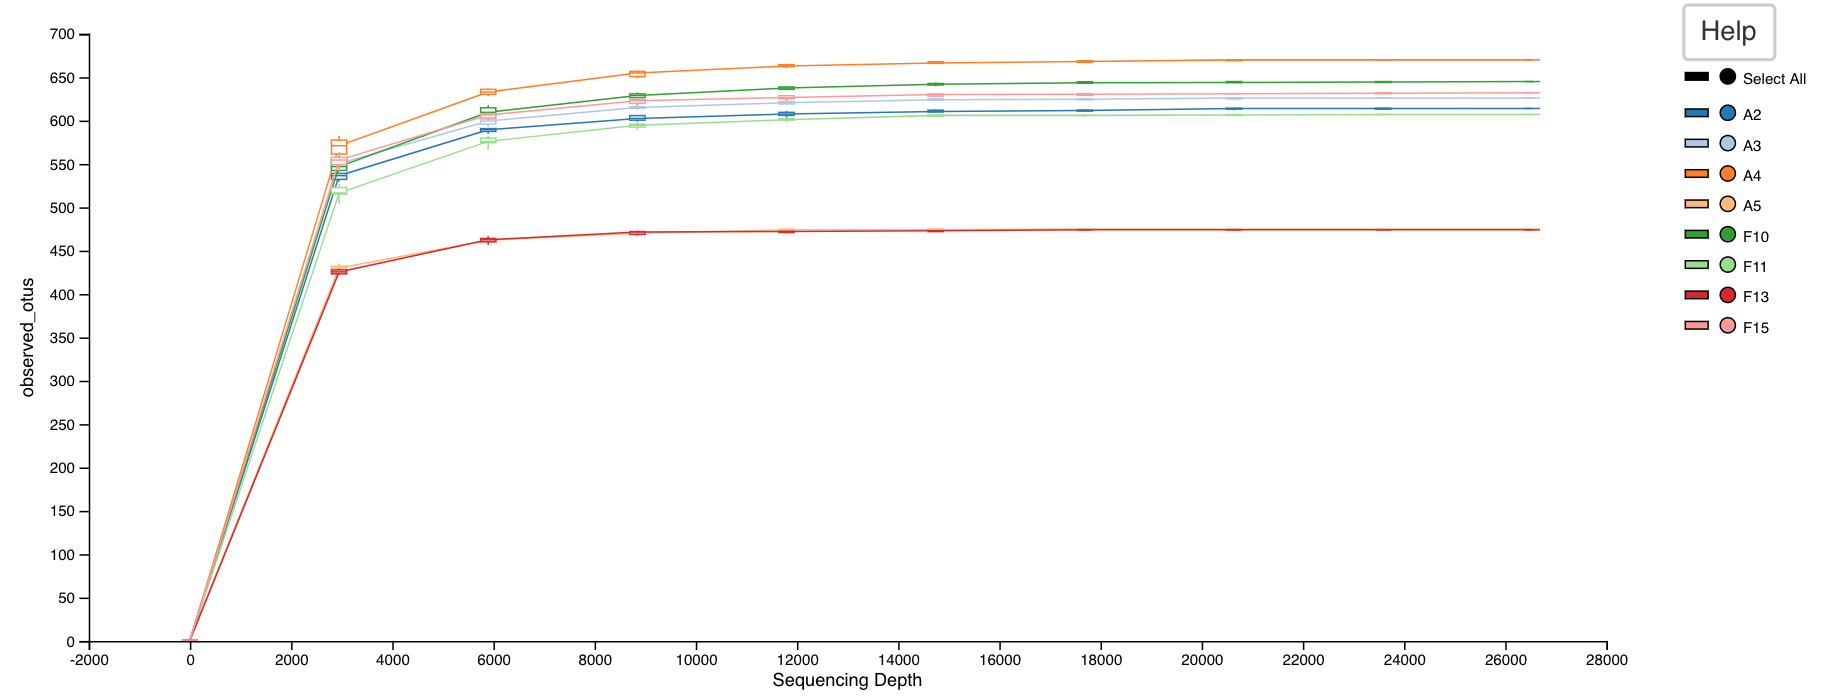
Demonstrates sufficient sampling depth. Most ASVs captured at ~2500,  plateau at ~10000 reads.

### Analysis of Beta Diversity Metrics by PERMANOVA  
Bray-Curtis (no incorporation of phylogeny/branch length information), Unweighted UniFrac (incorporates phylogeny, does not weight by relative abundance), and Weighted UniFrac. Used default of 999 permutations.

In [28]:
!qiime diversity beta-group-significance \
  --i-distance-matrix analyses/Yue/se-excl-mitochloro-corediv-26537/bray_curtis_distance_matrix.qza  \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column "Grouping" \
  --p-method permanova  \
  --o-visualization analyses/Yue/se-excl-mitochloro-corediv-26537/bray_curtis_permanova.qzv

!qiime diversity beta-group-significance \
  --i-distance-matrix analyses/Yue/se-excl-mitochloro-corediv-26537/weighted_unifrac_distance_matrix.qza  \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column "Grouping" \
  --p-method permanova  \
  --o-visualization analyses/Yue/se-excl-mitochloro-corediv-26537/weighted_unifrac_permanova.qzv

!qiime diversity beta-group-significance \
  --i-distance-matrix analyses/Yue/se-excl-mitochloro-corediv-26537/unweighted_unifrac_distance_matrix.qza  \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column "Grouping" \
  --p-method permanova  \
  --o-visualization analyses/Yue/se-excl-mitochloro-corediv-26537/unweighted_unifrac_permanova.qzv

Saved Visualization to: analyses/Yue/se-excl-mitochloro-corediv-26537/bray_curtis_permanova.qzv
Saved Visualization to: analyses/Yue/se-excl-mitochloro-corediv-26537/weighted_unifrac_permanova.qzv
Saved Visualization to: analyses/Yue/se-excl-mitochloro-corediv-26537/unweighted_unifrac_permanova.qzv


> #### Bray-Curtis
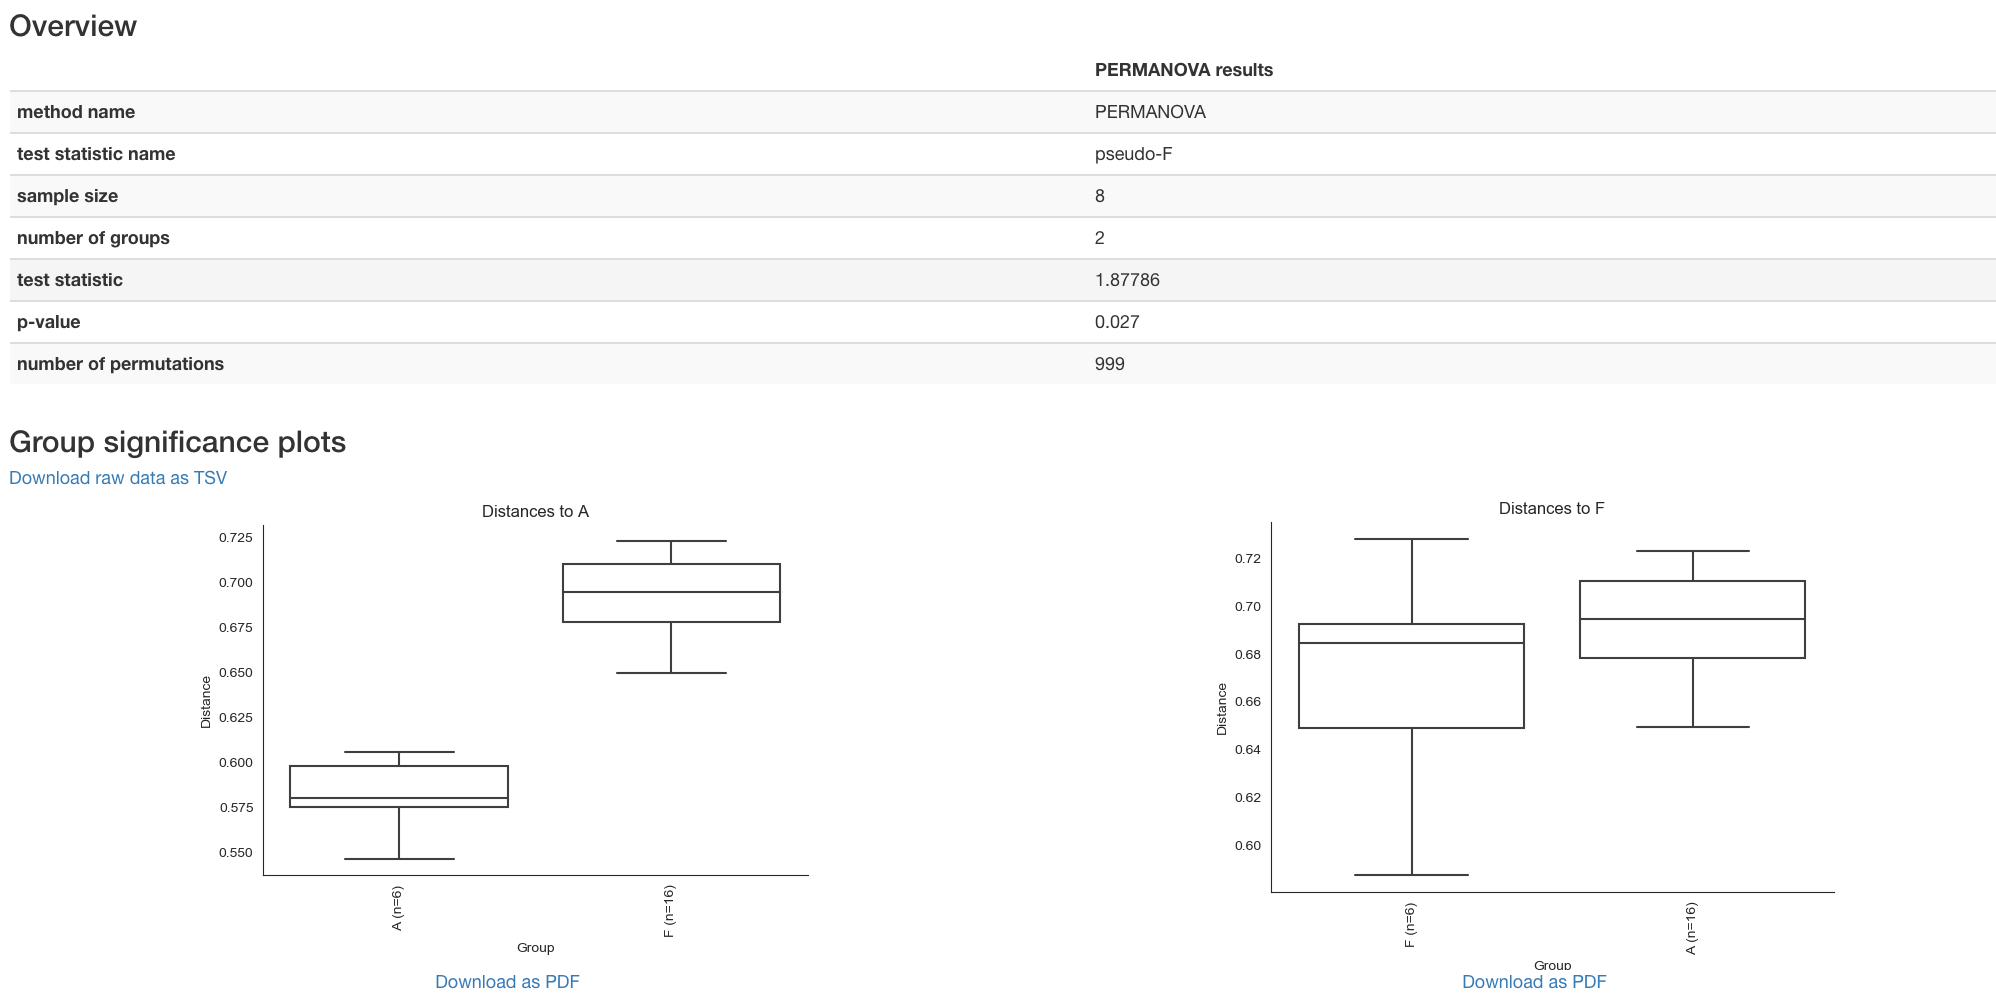

> #### Unweighted UniFrac
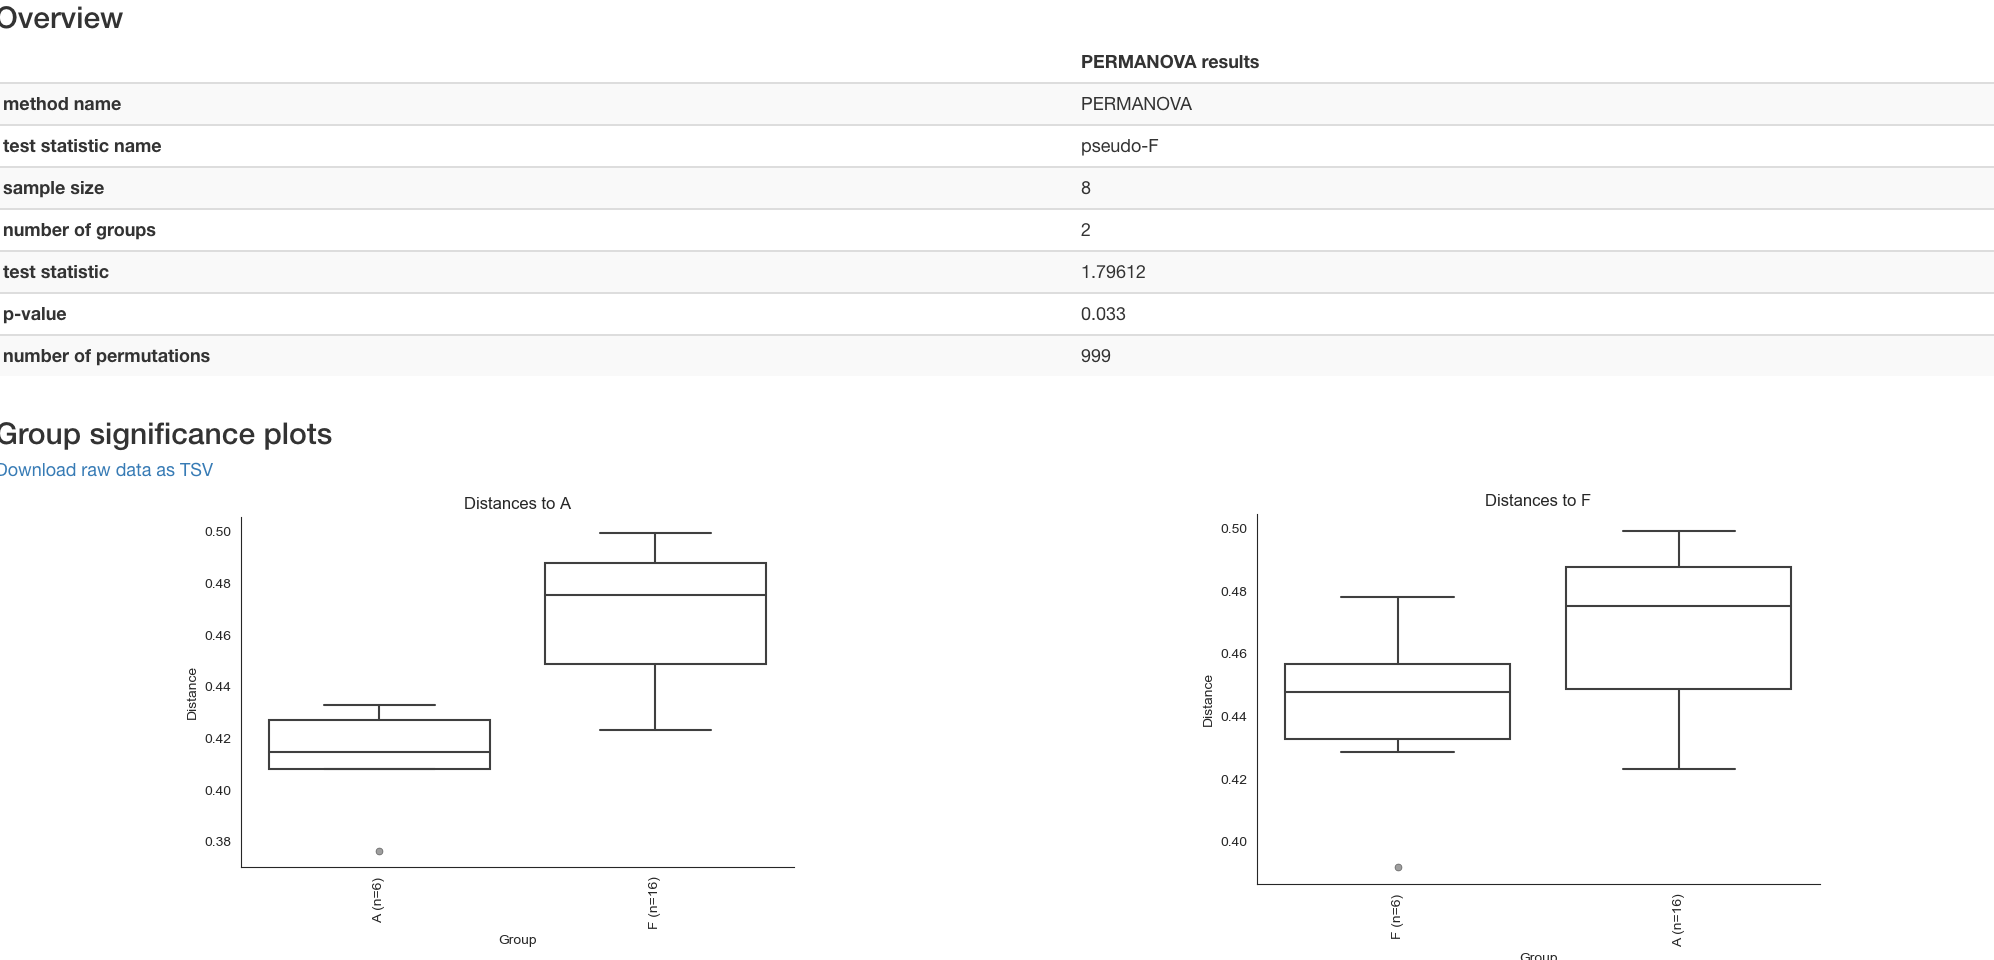

> #### Weighted UniFrac
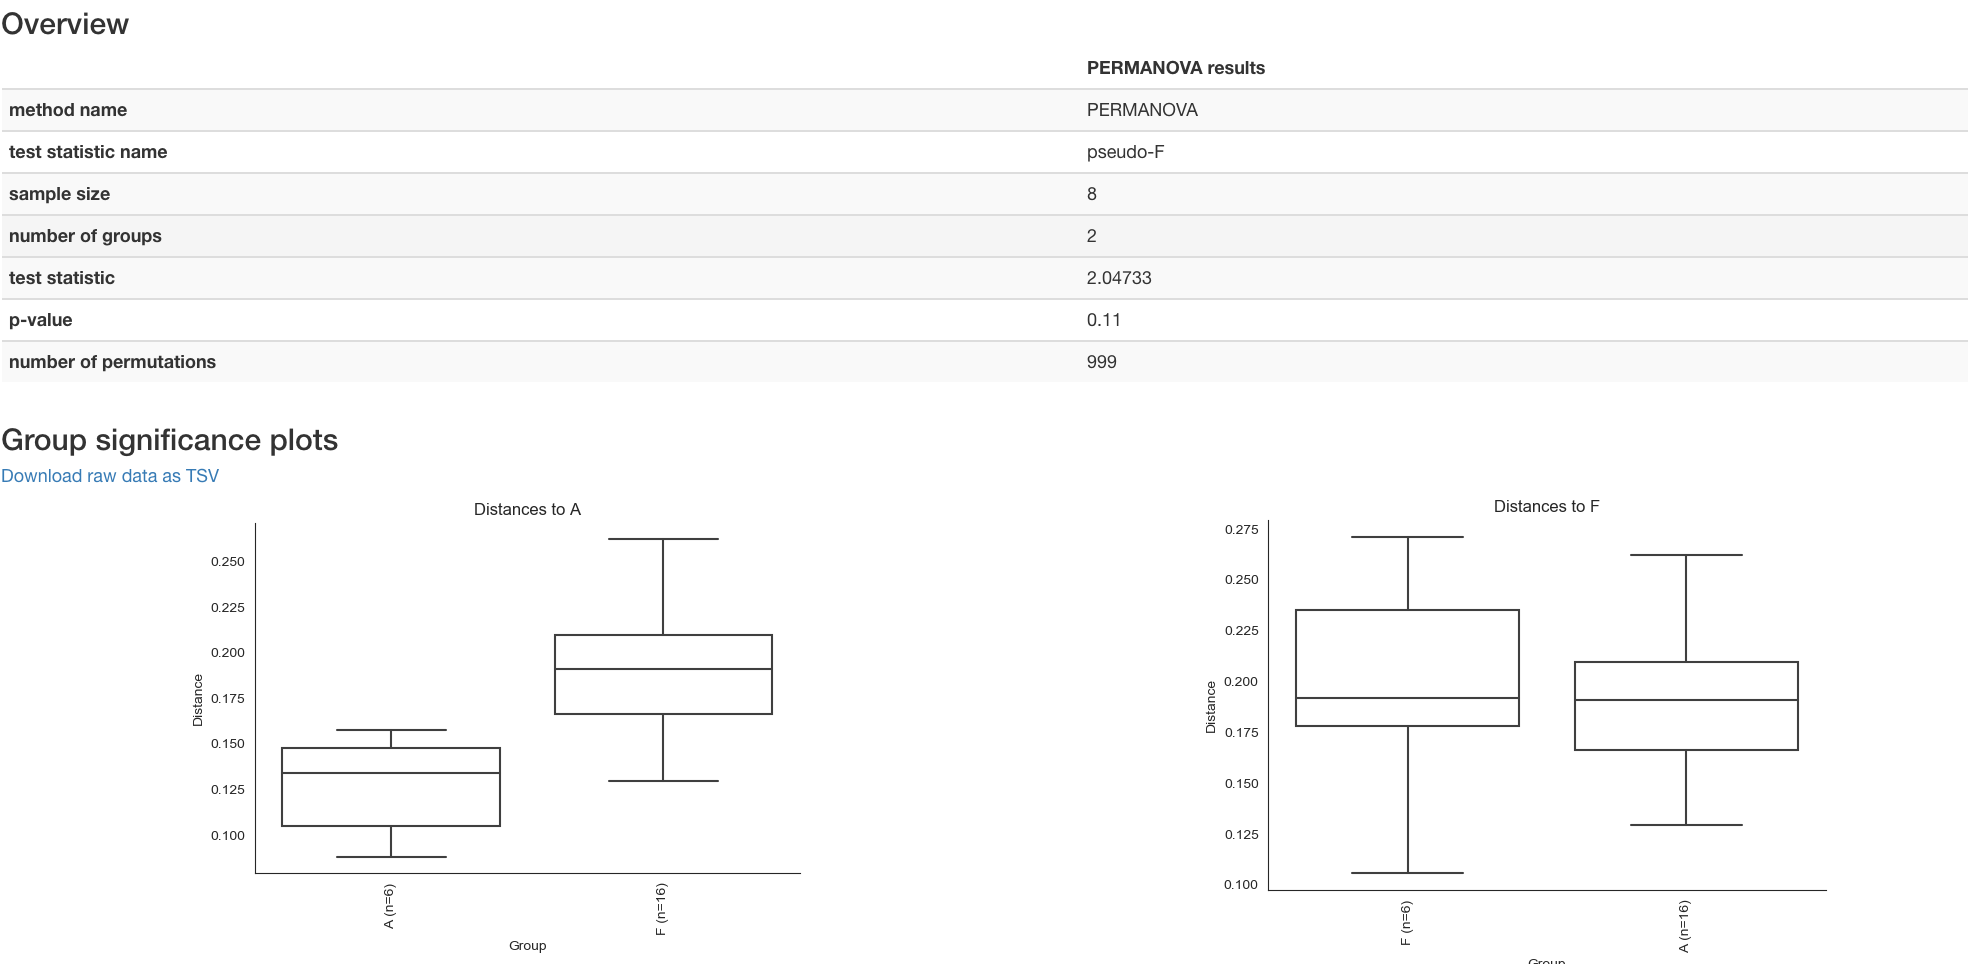

Divergence between PERMANOVA results for Bray-Curtis and UniFrac Metrics indicates that the taxa differing between groups A and F are closely related. This interpretation can be confirmed by differential abundance testing.

### 9) Differential Abundance Testing with Gneiss

In [31]:
!qiime gneiss correlation-clustering \
  --i-table data/Yue/se-table-excl-mitochloro.qza \
  --o-clustering analyses/Yue/se-hierarchy.qza

Saved Hierarchy to: analyses/Yue/se-hierarchy.qza


!qiime gneiss ilr-hierarchical \
  --i-table data/Yue/se-table-excl-mitochloro.qza \
  --i-tree analyses/Yue/se-hierarchy.qza \
  --o-balances analyses/Yue/se-balances.qza

   Added SimData to `scripts/mapping.txt` as an additional, though entirely made-up fictional variable to regress by. Will ultimately have more metadata categories for final elephant microbiome analyses.

In [36]:
!qiime gneiss ols-regression \
  --p-formula "Grouping+SimData" \
  --i-table analyses/Yue/se-balances.qza \
  --i-tree analyses/Yue/se-hierarchy.qza \
  --m-metadata-file scripts/mapping.txt \
  --o-visualization analyses/Yue/se-regression_summary.qzv

Saved Visualization to: analyses/Yue/se-regression_summary.qzv


In [37]:
!qiime gneiss dendrogram-heatmap \
  --i-table data/Yue/se-table-excl-mitochloro.qza \
  --i-tree analyses/Yue/se-hierarchy.qza \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column Grouping \
  --p-color-map seismic \
  --o-visualization analyses/Yue/se-heatmap.qzv

Saved Visualization to: analyses/Yue/se-heatmap.qzv


#### Making differential abundance summaries for phylum, order, and genus, split A vs. F

In [41]:
!qiime gneiss balance-taxonomy \
  --i-table data/Yue/se-table-excl-mitochloro.qza \
  --i-tree analyses/Yue/se-hierarchy.qza \
  --i-taxonomy analyses/Yue/se-silva-taxonomy.qza \
  --p-taxa-level 2 \
  --p-balance-name 'y0' \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column Grouping \
  --o-visualization analyses/Yue/se-y0_taxa_L2_summary.qzv

!qiime gneiss balance-taxonomy \
  --i-table data/Yue/se-table-excl-mitochloro.qza \
  --i-tree analyses/Yue/se-hierarchy.qza \
  --i-taxonomy analyses/Yue/se-silva-taxonomy.qza \
  --p-taxa-level 4 \
  --p-balance-name 'y0' \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column Grouping \
  --o-visualization analyses/Yue/se-y0_taxa_L4_summary.qzv

!qiime gneiss balance-taxonomy \
  --i-table data/Yue/se-table-excl-mitochloro.qza \
  --i-tree analyses/Yue/se-hierarchy.qza \
  --i-taxonomy analyses/Yue/se-silva-taxonomy.qza \
  --p-taxa-level 6 \
  --p-balance-name 'y0' \
  --m-metadata-file scripts/mapping.txt \
  --m-metadata-column Grouping \
  --o-visualization analyses/Yue/se-y0_taxa_L6_summary.qzv

Saved Visualization to: analyses/Yue/se-y0_taxa_L2_summary.qzv
Saved Visualization to: analyses/Yue/se-y0_taxa_L4_summary.qzv


> ### Differential abundance plot (taxa level 2/phylum), A vs. F, from `se-y0_taxa_L2_summary.qzv`
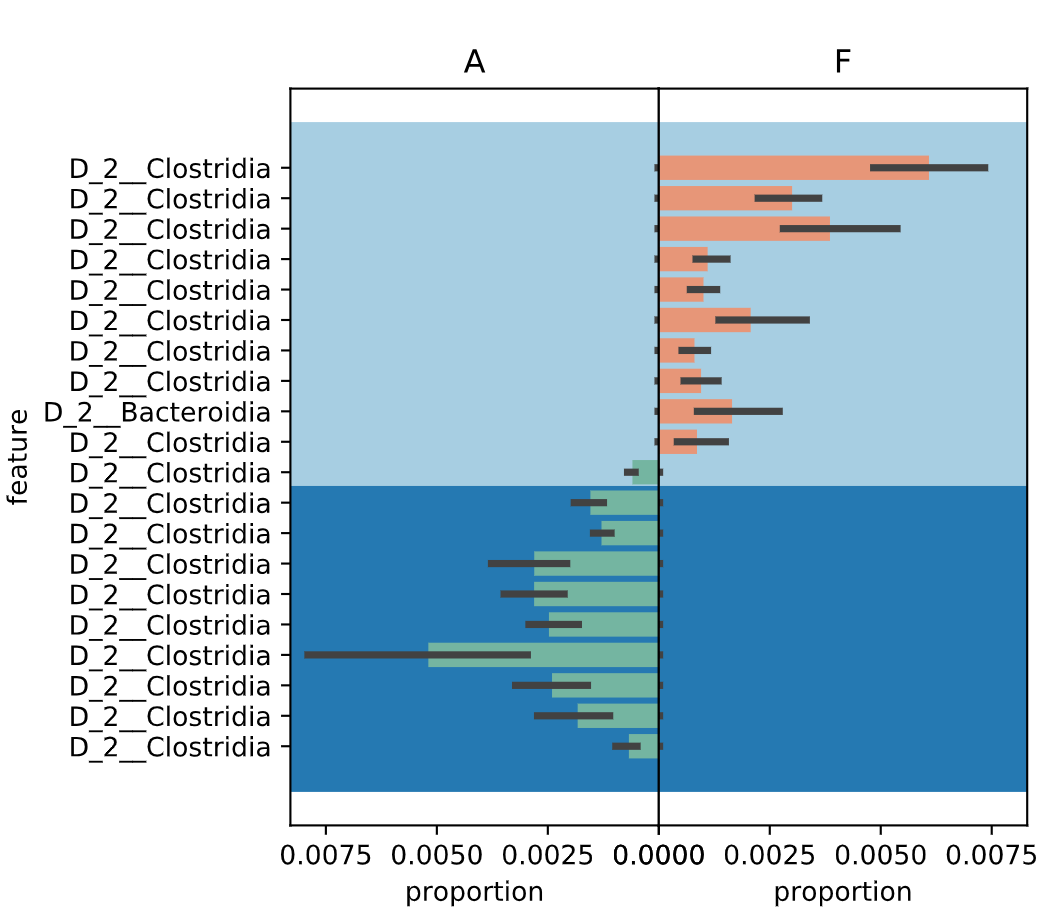

> ### Differential abundance plot (taxa level 4/order), A vs. F, from `se-y0_taxa_L4_summary.qzv`
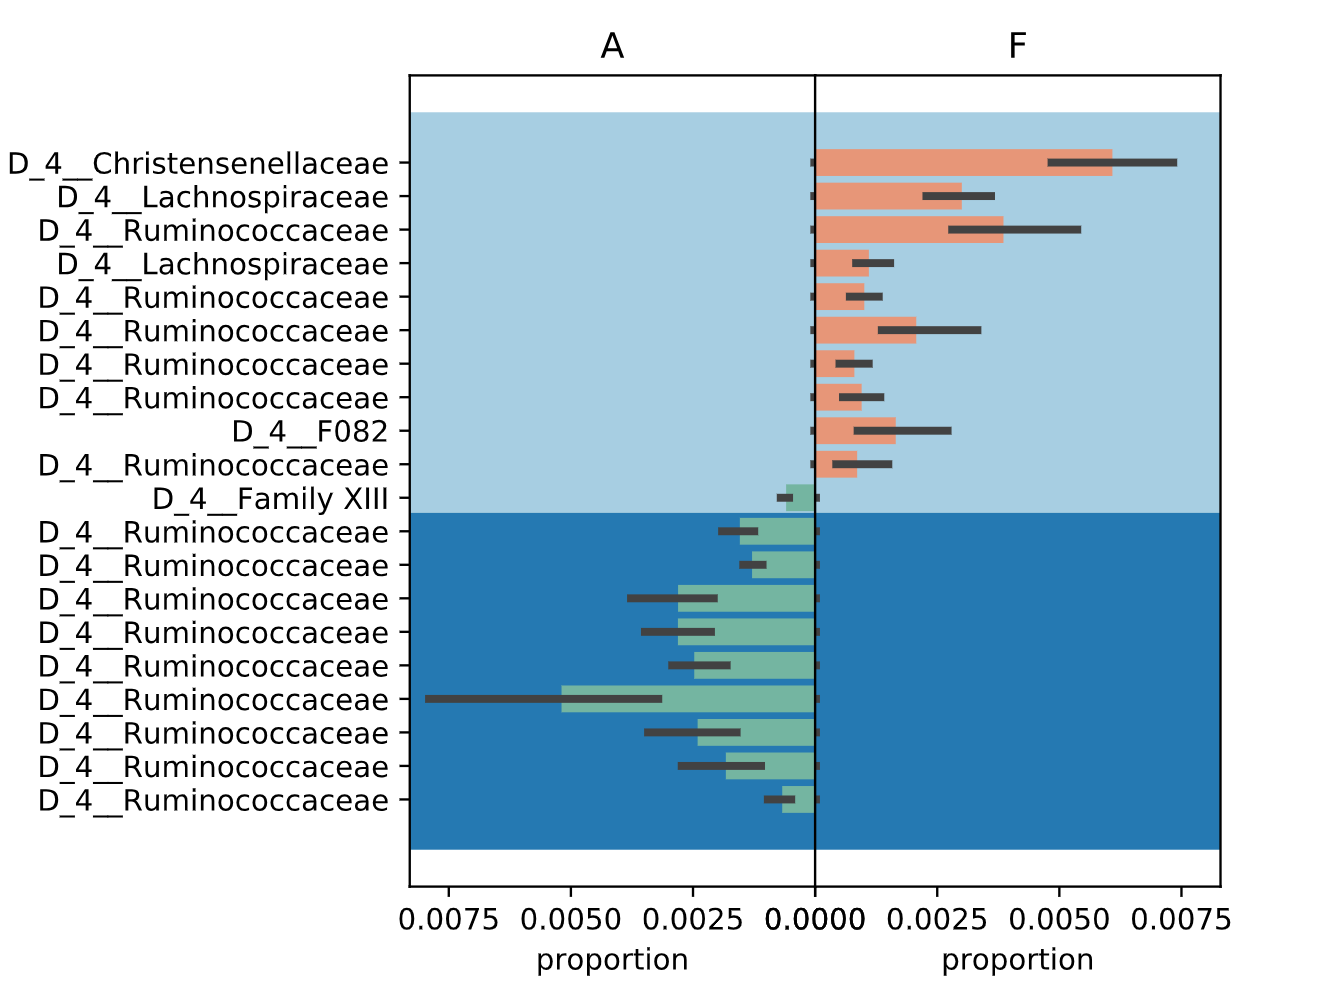
> Differential abundance testing shows that indeed the taxa responsible for the differing structure of A vs. F are mostly from the same order, Ruminococcaceae.


>### Differential abundance plot (taxa level 6/genus), A vs. F, from `se-y0_taxa_L6_summary.qzv`
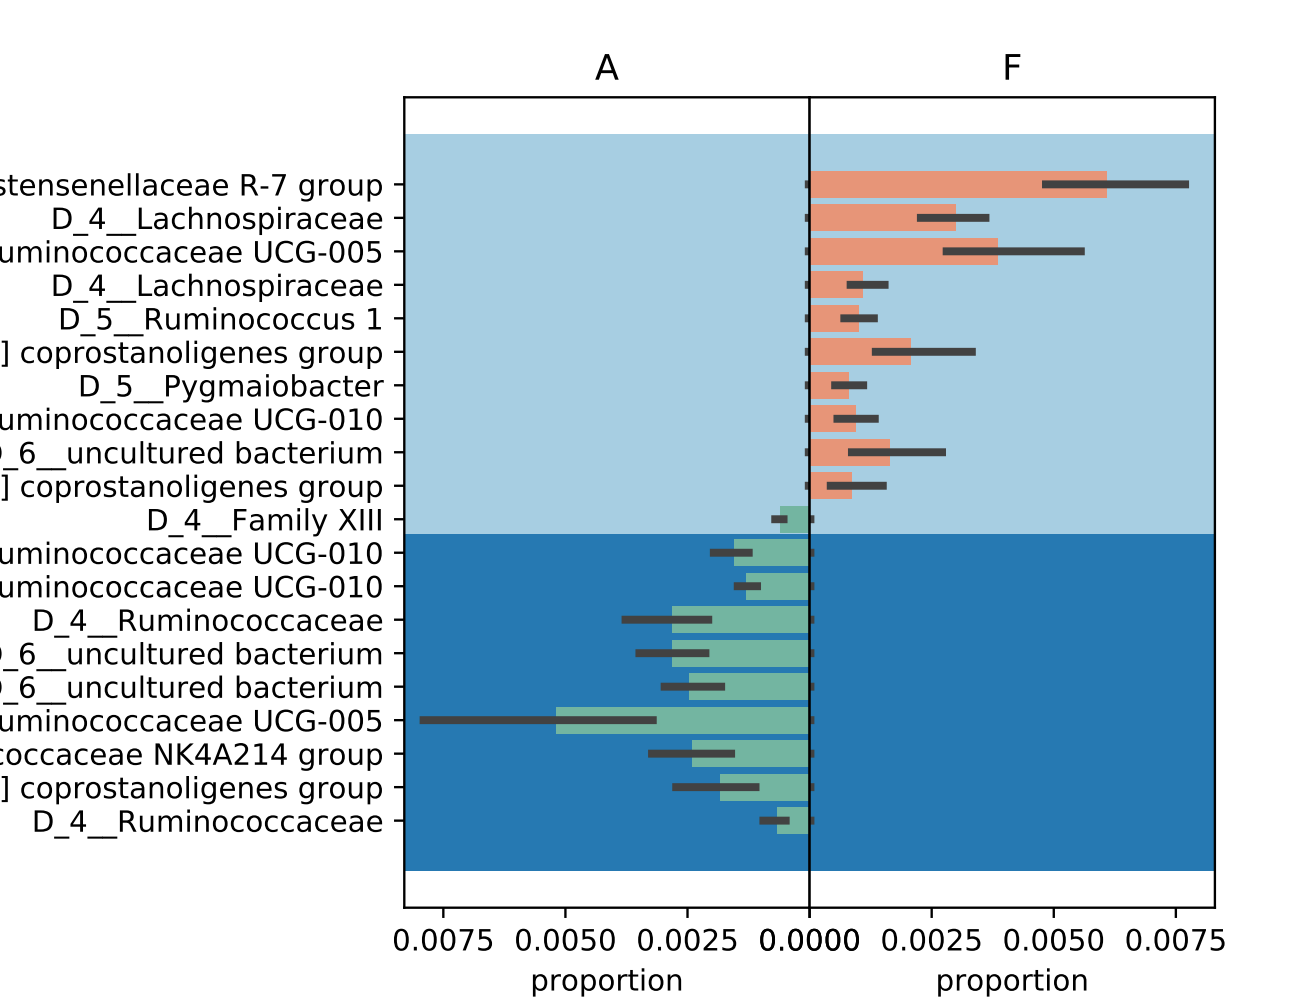


### 10) Functional profiling of microbiome with PICRUSt
PICRUSt uses 16S count data to estimate the gene families contributed by each member of the microbiome.

First, download the PICRUSt reference phylogeny and tree

In [43]:
!wget http://kronos.pharmacology.dal.ca/public_files/tutorial_datasets/picrust2_tutorial_files/reference.fna.qza > data/PICRUSt-reference.fna.qza
!wget http://kronos.pharmacology.dal.ca/public_files/tutorial_datasets/picrust2_tutorial_files/reference.tre.qza > data/PICRUSt-reference.tre.qza

--2018-11-02 15:56:51--  http://kronos.pharmacology.dal.ca/public_files/tutorial_datasets/picrust2_tutorial_files/reference.fna.qza
Resolving kronos.pharmacology.dal.ca... 129.173.80.34
Connecting to kronos.pharmacology.dal.ca|129.173.80.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4408600 (4.2M)
Saving to: 'reference.fna.qza'

reference.fna.qza   100%[===================>]   4.20M   851KB/s    in 4.9s    

2018-11-02 15:56:56 (884 KB/s) - 'reference.fna.qza' saved [4408600/4408600]

--2018-11-02 15:56:56--  http://kronos.pharmacology.dal.ca/public_files/tutorial_datasets/picrust2_tutorial_files/reference.tre.qza
Resolving kronos.pharmacology.dal.ca... 129.173.80.34
Connecting to kronos.pharmacology.dal.ca|129.173.80.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191187 (187K)
Saving to: 'reference.tre.qza'

reference.tre.qza   100%[===================>] 186.71K   379KB/s    in 0.5s    

2018-11-02 15:56:57 (379 KB/s) - 'refer

In [51]:
!qiime fragment-insertion sepp \
    --i-representative-sequences data/Yue/se-rep-seqs.qza \
    --p-threads 1 \
    --i-reference-alignment data/reference.fna.qza \
    --i-reference-phylogeny data/reference.tre.qza \
    --output-dir data/Yue/se-frag-tree/

Saved Phylogeny[Rooted] to: data/Yue/se-frag-tree/tree.qza
Saved Placements to: data/Yue/se-frag-tree/placements.qza


In [ ]:
!qiime picrust2 custom-tree-pipeline --i-table data/Yue/se-table-excl-mitochloro.qza \
                                    --i-tree data/Yue/se-frag-tree/tree.qza \
                                    --output-dir analyses/Yue/q2-picrust2_output \
                                    --p-threads 1 --p-hsp-method mp \
                                    --p-max-nsti 2